In [1]:
import torch
import pandas as pd
import numpy as np
SEED = 10

In [2]:
np.random.seed(SEED)
torch.manual_seed(SEED)

In [36]:
torch.cuda.is_available()

True

# Data prepocessing

In [3]:
dataset_1 = pd.read_csv('synth-data.csv', encoding='utf-8')
dataset_1 = dataset_1.drop(["affirmative","negative","question"], axis=1)

dataset_2 = pd.read_csv('ted-label.csv', encoding='utf-8')
dataset_2 = dataset_2.drop(["predicted_type","data_trash","sentence_id","date"], axis=1)
dataset_2 = dataset_2[dataset_2['actual_type'] != 'trash']

dataset_1 = dataset_1.rename(columns={'sentences': 'sent'})
dataset_2 = dataset_2.rename(columns={'sentence': 'sent', 'actual_type': 'type'})

dataset = pd.concat([dataset_1, dataset_2])
dataset.to_csv("all-sents.csv", encoding='utf-8', index=False)

In [7]:
# types_list = list(set(dataset['type'].to_list()))
# SENT_TYPES = {types_list[i]:i for i in range(len(types_list))}

In [4]:
SENT_TYPES = {'present_continuous': 0,
            'to_be_future': 1,
            'past_continuous': 2,
            'past_simple': 3,
            'can': 4,
            'future_simple': 5,
            'to_be_present': 6,
            'used_to': 7,
            'to_be_past': 8,
            'present_simple': 9,
            'other': 10,
            'present_perfect': 11,
            'could': 12}

In [5]:
def convert_type_to_number(dataframe, SENT_TYPES=SENT_TYPES):
    for i in range(len(dataframe['type'])):
        sent_type = str(dataframe['type'][i])
        dataframe['type'][i] = SENT_TYPES[sent_type]
    return dataframe

In [6]:
dataset = convert_type_to_number(pd.read_csv("all-sents.csv"))

In [7]:
dataset.to_csv("all-sents.csv", encoding='utf-8', index=False)

# Split Data

In [8]:
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer
from catalyst.utils import set_global_seed
import logging

In [9]:
params = {
    'data': {
        'text_field_name': 'sent',
        'label_field_name': 'type',
        'path_to_dataset': 'all-sents.csv',
        'path_to_test_pred_scores': 'data/pred.txt'
    },
    'model': {
        'max_seq_length': 128,
        'model_name': 'distilbert-base-uncased',
        'num_classes': 13
    },
    'training': {
        'learn_rate': 1e-5,
        'num_epochs': 3,                          
        'accum_steps': 2,                         
        'batch_size': 2,                         
        'log_dir': 'logdir' 
    }
}

In [10]:
def read_data(params):
    dataset = pd.read_csv(params['data']['path_to_dataset'], encoding='utf-8')
    dataset = dataset.sample(frac=1)
    train, valid, test = np.split(dataset, 
               [int(.8*len(dataset)), int(.9*len(dataset))])
    test.to_csv('test.csv', encoding='utf-8', index=False)
    # creating PyTorch Datasets
    train_dataset = TextClassificationDataset(
        texts=train[params["data"]["text_field_name"]].values.tolist(),
        labels=train[params["data"]["label_field_name"]].values,
        max_seq_length=params["model"]["max_seq_length"],
        model_name=params["model"]["model_name"],
    )

    valid_dataset = TextClassificationDataset(
        texts=valid[params["data"]["text_field_name"]].values.tolist(),
        labels=valid[params["data"]["label_field_name"]].values,
        max_seq_length=params["model"]["max_seq_length"],
        model_name=params["model"]["model_name"],
    )

    test_dataset = TextClassificationDataset(
        texts=test[params["data"]["text_field_name"]].values.tolist(),
        labels=test[params["data"]["label_field_name"]].values,
        max_seq_length=params["model"]["max_seq_length"],
        model_name=params["model"]["model_name"],
    )

    set_global_seed(SEED)

    # creating PyTorch data loaders and placing them in dictionaries (for Catalyst)
    train_val_loaders = {
        "train": DataLoader(
            dataset=train_dataset,
            batch_size=params["training"]["batch_size"],
            shuffle=True,
        ),
        "valid": DataLoader(
            dataset=valid_dataset,
            batch_size=params["training"]["batch_size"],
            shuffle=False,
        ),
    }

    test_loaders = {
        "test": DataLoader(
            dataset=test_dataset,
            batch_size=params["training"]["batch_size"],
            shuffle=False,
        )
    }

    return train_val_loaders, test_loaders

In [11]:
class TextClassificationDataset(Dataset):
    def __init__(
        self,
        texts,
        labels = None,
        label_dict = None,
        max_seq_length = 128,
        model_name = "distilbert-base-uncased",
    ):
        self.texts = texts
        self.labels = labels
        self.label_dict = label_dict
        self.max_seq_length = max_seq_length

        if self.label_dict is None and labels is not None:
            # {'class1': 0, 'class2': 1, 'class3': 2, ...}
            # using this instead of `sklearn.preprocessing.LabelEncoder`
            # no easily handle unknown target values
            self.label_dict = dict(zip(sorted(set(labels)), range(len(set(labels)))))

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        # suppresses tokenizer warnings
        logging.getLogger("transformers.tokenization_utils").setLevel(logging.FATAL)

        
        self.sep_vid = self.tokenizer.vocab["[SEP]"]
        self.cls_vid = self.tokenizer.vocab["[CLS]"]
        self.pad_vid = self.tokenizer.vocab["[PAD]"]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):

        # encoding the text
        x = self.texts[index]

        # a dictionary with `input_ids` and `attention_mask` as keys
        output_dict = self.tokenizer.encode_plus(
            x,
            add_special_tokens=True,
            padding="max_length",
            max_length=self.max_seq_length,
            return_tensors="pt",
            truncation=True,
            return_attention_mask=True,
        )

        # for Catalyst, there needs to be a key called features
        output_dict["features"] = output_dict["input_ids"].squeeze(0)
        del output_dict["input_ids"]

        # encoding target
        if self.labels is not None:
            y = self.labels[index]
            y_encoded = torch.Tensor([self.label_dict.get(y, -1)]).long().squeeze(0)
            output_dict["targets"] = y_encoded

        return output_dict

# Bert Model Classifier

In [12]:
from transformers import AutoConfig, AutoModel
import torch.nn as nn

In [13]:
class BertForSequenceClassification(nn.Module):
    """
    Simplified version of the same class by HuggingFace.
    See transformers/modeling_distilbert.py in the transformers repository.
    """

    def __init__(
        self, pretrained_model_name, num_classes = None, dropout = 0.3
    ):
        super().__init__()

        config = AutoConfig.from_pretrained(
            pretrained_model_name, num_labels=num_classes
        )

        self.model = AutoModel.from_pretrained(pretrained_model_name, config=config)
        # self.classifier = nn.Linear(config.hidden_size, num_classes)
        # self.dropout = nn.Dropout(dropout)
        self.pre_classifier = nn.Linear(config.dim, config.dim)
        self.classifier = nn.Linear(config.dim, num_classes)
        self.dropout = nn.Dropout(config.seq_classif_dropout)

    def forward(self, features, attention_mask=None, head_mask=None):
        """Compute class probabilities for the input sequence.

        Args:
            features (torch.Tensor): ids of each token,
                size ([bs, seq_length]
            attention_mask (torch.Tensor): binary tensor, used to select
                tokens which are used to compute attention scores
                in the self-attention heads, size [bs, seq_length]
            head_mask (torch.Tensor): 1.0 in head_mask indicates that
                we keep the head, size: [num_heads]
                or [num_hidden_layers x num_heads]
        Returns:
            PyTorch Tensor with predicted class scores
        """
        assert attention_mask is not None, "attention mask is none"

        # taking BERTModel output
        # see https://huggingface.co/transformers/model_doc/bert.html#transformers.BertModel
        distilbert_output = self.model(
            input_ids=features, attention_mask=attention_mask, head_mask=head_mask
        )
        # we only need the hidden state here and don't need
        # transformer output, so index 0
        # seq_output = bert_output[0]  # (bs, seq_len, dim)
        # mean pooling, i.e. getting average representation of all tokens
        # pooled_output = seq_output.mean(axis=1)  # (bs, dim)
        # pooled_output = self.dropout(pooled_output)  # (bs, dim)
        # scores = self.classifier(pooled_output)  # (bs, num_classes)

        hidden_state = distilbert_output[0]  # (bs, seq_len, dim)
        pooled_output = hidden_state[:, 0]  # (bs, dim)
        pooled_output = self.pre_classifier(pooled_output)  # (bs, dim)
        pooled_output = nn.ReLU()(pooled_output)  # (bs, dim)
        pooled_output = self.dropout(pooled_output)  # (bs, dim)
        logits = self.classifier(pooled_output)  # (bs, num_labels)

        return logits

# Train Bert Classifier

In [14]:
from catalyst.dl import SupervisedRunner
from catalyst.dl.callbacks import (
    AccuracyCallback,
    CheckpointCallback,
    InferCallback,
    OptimizerCallback,
)
from catalyst.utils import prepare_cudnn, set_global_seed

In [15]:
train_val_loaders, test_loaders = read_data(params)

In [16]:
model = BertForSequenceClassification(
    pretrained_model_name=params["model"]["model_name"],
    num_classes=params["model"]["num_classes"],
)


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=float(params["training"]["learn_rate"])
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
set_global_seed(SEED)
prepare_cudnn(deterministic=True)
runner = SupervisedRunner(input_key=("features", "attention_mask"))

In [17]:
from GPUtil import showUtilization as gpu_usage
import gc
gc.collect()
torch.cuda.empty_cache()
gpu_usage()   

| ID | GPU | MEM |
------------------
|  0 |  0% | 56% |


In [32]:
torch.cuda.empty_cache()
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=train_val_loaders,
    callbacks=[
        AccuracyCallback(num_classes=int(params["model"]["num_classes"]), topk_args=[1]),
        # OptimizerCallback(accumulation_steps=int(
        #     params["training"]["accum_steps"])),
    ],
    logdir=params["training"]["log_dir"],
    num_epochs=int(params["training"]["num_epochs"]),
    verbose=True,
)

1/3 * Epoch (train): 100% 497/497 [01:10<00:00,  7.06it/s, accuracy01=1.000, loss=0.414]
1/3 * Epoch (valid): 100% 62/62 [00:01<00:00, 36.07it/s, accuracy01=0.000e+00, loss=1.814]
[2021-01-08 04:23:16,953] 
1/3 * Epoch 1 (_base): lr=1.000e-05 | momentum=0.9000
1/3 * Epoch 1 (train): accuracy01=0.3333 | loss=2.0054
1/3 * Epoch 1 (valid): accuracy01=0.6210 | loss=1.3325
2/3 * Epoch (train): 100% 497/497 [01:11<00:00,  6.98it/s, accuracy01=1.000, loss=0.158]
2/3 * Epoch (valid): 100% 62/62 [00:01<00:00, 39.26it/s, accuracy01=1.000, loss=0.544]
[2021-01-08 04:25:00,452] 
2/3 * Epoch 2 (_base): lr=1.000e-05 | momentum=0.9000
2/3 * Epoch 2 (train): accuracy01=0.7744 | loss=0.9821
2/3 * Epoch 2 (valid): accuracy01=0.8065 | loss=0.6812
3/3 * Epoch (train): 100% 497/497 [01:09<00:00,  7.13it/s, accuracy01=0.000e+00, loss=0.930]
3/3 * Epoch (valid): 100% 62/62 [00:01<00:00, 33.60it/s, accuracy01=0.500, loss=1.962]
[2021-01-08 04:26:42,998] 
3/3 * Epoch 3 (_base): lr=1.000e-05 | momentum=0.9000
3

In [18]:
torch.cuda.empty_cache()
with torch.no_grad():
    runner.infer(
        model=model,
        loaders=test_loaders,
        callbacks=[
            CheckpointCallback(
                resume=f"{params['training']['log_dir']}/checkpoints/best.pth"
            ),
            InferCallback(),
        ],
        verbose=True,
    )

=> Loading checkpoint logdir/checkpoints/best.pth
loaded state checkpoint logdir/checkpoints/best.pth (global epoch 3, epoch 3, stage train)
1/1 * Epoch (test): 100% 63/63 [00:01<00:00, 36.82it/s]


In [19]:
torch.cuda.empty_cache()
gpu_usage() 

| ID | GPU | MEM |
------------------
|  0 |  0% | 72% |


# Run Metrics

In [20]:
from sklearn.metrics import (
    f1_score, 
    confusion_matrix, 
    accuracy_score, 
    roc_auc_score,
    classification_report
)
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [21]:
# lastly, saving predicted scores for the test set
predicted_scores = runner.callbacks[0].predictions["logits"]
# np.savetxt(X=predicted_scores,
#            fname=params["data"]["path_to_test_pred_scores"])

## F1

In [22]:
y_pred = predicted_scores.argmax(axis=1)
y_true = pd.read_csv('test.csv', encoding='utf-8')
y_true = np.array(y_true['type'].to_list())
f1_score(y_true, y_pred, average='micro'),f1_score(y_true, y_pred, average='macro'),f1_score(y_true, y_pred, average='weighted')

(0.952, 0.9412515588986176, 0.9515946014769545)

## All metrics

In [23]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.83      1.00      0.91         5
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00        12
           4       0.83      1.00      0.91         5
           5       1.00      0.75      0.86         4
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00         5
           8       0.89      1.00      0.94         8
           9       0.97      1.00      0.98        31
          10       1.00      0.87      0.93        30
          11       0.83      1.00      0.91         5
          12       0.83      1.00      0.91         5

    accuracy                           0.95       125
   macro avg       0.94      0.96      0.94       125
weighted avg       0.96      0.95      0.95       125



## Accuracy

In [24]:
accuracy_score(y_true, y_pred)

0.952

## Confusion Matrix

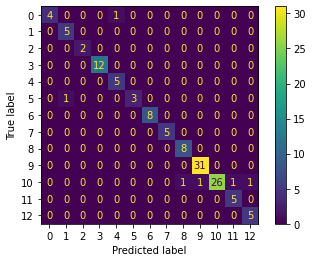

In [25]:
labels = [i for i in range(params['model']['num_classes'])]
cm = confusion_matrix(
        y_true, y_pred, 
        labels=np.array(labels))

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() 

# Visual checking 

In [26]:
from catalyst import utils

In [27]:
SENT_TYPES_INVERSE = {i:item for i, item in enumerate(SENT_TYPES)}

In [28]:
SENT_TYPES_INVERSE

{0: 'present_continuous',
 1: 'to_be_future',
 2: 'past_continuous',
 3: 'past_simple',
 4: 'can',
 5: 'future_simple',
 6: 'to_be_present',
 7: 'used_to',
 8: 'to_be_past',
 9: 'present_simple',
 10: 'other',
 11: 'present_perfect',
 12: 'could'}

In [29]:
def predict_sent_type(sent):
    with torch.no_grad():
        x = sent
        tokenizer = AutoTokenizer.from_pretrained(params['model']['model_name'])
        output_dict = tokenizer.encode_plus(
                x,
                add_special_tokens=True,
                padding="max_length",
                max_length=params['model']['max_seq_length'],
                return_tensors="pt",
                truncation=True,
                return_attention_mask=True,
            )
        bert_model = BertForSequenceClassification(
            pretrained_model_name=params["model"]["model_name"],
            num_classes=params["model"]["num_classes"],
        )
        bert_model.cuda()
        bert_model.eval()

        checkpoint = utils.checkpoint.load_checkpoint(filepath="./logdir/checkpoints/best.pth")
        utils.checkpoint.unpack_checkpoint(
            checkpoint=checkpoint,
            model=bert_model,
            # optimizer=optimizer,
            # criterion=criterion
            )
        output = bert_model(output_dict['input_ids'].cuda(), output_dict['attention_mask'].cuda())
        output = int(torch.argmax(output).item())
        result = f'{sent} - {SENT_TYPES_INVERSE[output]}'
        return result

In [30]:
predict_sent_type('I can fly')

'I can fly - can'

In [43]:
test_sents = [
    'I believe I can fly',
    'I wanted to be a dentist',
    'I could die when I was young, but I was saved by the doctors',
    'They will kill the bird',
    'She used not to live as poorly as she does now.',
    "He got at 8, then he went to school, where surprisingly he didn't see anyone because they didn't have classes on Sundays, even though he though differently",
    'I did it'
]

In [44]:
for item in test_sents:
    res = predict_sent_type(item)
    print(res)

I believe I can fly - can
I wanted to be a dentist - past_simple
I could die when I was young, but I was saved by the doctors - other
They will kill the bird - future_simple
She used not to live as poorly as she does now. - other
He got at 8, then he went to school, where surprisingly he didn't see anyone because they didn't have classes on Sundays, even though he though differently - past_simple
I did it - past_simple


## Present Simple


In [31]:
present_simple = [
    'Do you play the piano?',
    'Do Rita and Angela live in Manchester?',
    'What does Angela do?',
    'Who plays football at the weekend?',
    "I don't play the piano but I play the guitar.",
    "I don't live in London now.",
    "John doesn't live in Manchester.",
    "Light travels at almost 300,000 kilometres per second.",
    "The school term starts next week.",
    "I'll talk to John when I see him."
]
for sent in present_simple:
    print(predict_sent_type(sent))

Do you play the piano? - present_simple
Do Rita and Angela live in Manchester? - present_simple
What does Angela do? - present_simple
Who plays football at the weekend? - present_simple
I don't play the piano but I play the guitar. - present_simple
I don't live in London now. - present_simple
John doesn't live in Manchester. - present_simple
Light travels at almost 300,000 kilometres per second. - present_simple
The school term starts next week. - present_simple
I'll talk to John when I see him. - future_simple


## Present Perfect

In [ ]:
present_perfect = [
    "They've been married for nearly fifty years.",
    'She has lived in Liverpool all her life.',
    "I've seen that film before.",
    "I've played the guitar ever since I was a teenager.",
    "He has written three books and he is working on another one.",
    "Yes, but I've never met his wife.",
    "I can't get in the house. I've lost my keys.",
    "Teresa isn't at home. I think she has gone shopping.",
    "Have you ever been to San Francisco?",
    "No, but I've been to Los Angeles.",
    "Have you finished your homework yet?",
    "No, so far I've only done my history."
]
for sent in present_perfect:
    print(predict_sent_type(sent))

## Present Continuous

In [67]:
present_continuous = [
    "I'm just leaving work.",
    "The children are sleeping.",
    "Mary is going to a new school next term.",
    "What are you doing next week?",
    "Are you listening?",
    "When is she going home?",
    "Are they coming to your party?",
    "hey aren't coming to the party.",
    "These days most people are using email instead of writing letters.",
    "I'm working in London for the next two weeks.",
    "He's studying history.",
    "The children are growing up quickly.",
]
for sent in present_continuous:
    print(predict_sent_type(sent))

I'm just leaving work. - present_continuous
The children are sleeping. - present_continuous
Mary is going to a new school next term. - present_continuous
What are you doing next week? - present_continuous
Are you listening? - present_continuous
When is she going home? - present_continuous
Are they coming to your party? - present_continuous
hey aren't coming to the party. - present_continuous
These days most people are using email instead of writing letters. - other
I'm working in London for the next two weeks. - present_continuous
He's studying history. - present_continuous
The children are growing up quickly. - present_continuous


## Text Checking

In [86]:
import spacy 

nlp = spacy.load('en_core_web_sm')
some_text = """
My working day starts very early. From Monday to Friday I get up at half past three and I have a shower and a cup of coffee. I usually leave the house at ten past four because the car always arrives a few minutes early. I get to the studio at about five o'clock and start work. My programme Good Morning Britain starts at seven o'clock and finishes at nine o'clock. Then I leave the studio at a quarter past ten. After that, I go shopping and visit some friends. I get home at three o'clock. A woman helps me with the housework and the ironing. I read a newspaper and do some work.
"""

for sent in nlp(some_text).sents:
    sent = str(sent)
    print(predict_sent_type(sent))


My working day starts very early. - present_simple
From Monday to Friday I get up at half past three - present_simple
and I have a shower and a cup of coffee. - present_simple
I usually leave the house at ten past four because the car always arrives a few minutes early. - present_simple
I get to the studio at about five o'clock and start work. - present_simple
My programme Good Morning Britain starts at seven o'clock and finishes at nine o'clock. - present_simple
Then I leave the studio at a quarter past ten. - present_simple
After that, I go shopping and visit some friends. - present_simple
I get home at three o'clock. - present_simple
A woman helps me with the housework and the ironing. - present_simple
I read a newspaper and do some work.
 - present_simple


# GPT-2 Test

In [33]:
import spacy 

nlp = spacy.load('en_core_web_sm')
some_text = """
He makes a living doing commercials for some of those companies, right?  
I get to meet his wife, Marla, on a regular basis, just to make sure we get along.
I for example are the guys who pull the levers and pull the car seats off.  
As a whole, we use about 30 percent less energy.  
But when it comes to the human brain, my opinion varies widely.
He is not talking about a race between Trump supporters - instead it's talking about what we see in our hearts when we look at the world in these images.  
We're talking about what happens when you take into account all those other factors. 
She of course, does not like to talk about it.  
And then I see the faces of the foreign fighters.  
And he goes to the hospital and they kill the monsters, the madmen.  
They to the moon (or something) and back again.  
I mean, how many times have you seen me go up and try to cut a person's throat?  
The last step towards happiness comes from living in harmony with nature.  I
You to die at the hands of a gang of homicidal gangies?  
I know two things that I want you to know about myself, I tell ya.  
The day the polls close, I kill myself to make room for the rest of
Dog the remaining six brothers and sister out of college.  
You really start seeing it in movies like The Grand Budapest Sinner because they make the heroes.  
I think the idea of a city that's in the middle of nowhere becomes incredibly interesting in
It does seem to have a knack for making you cringe a little bit at the expense of your emotions.  
You know, I remember when they called it the 'Washbine Bowl Massacre'.
I mean, I think the people who actually pay for the movies that they see are the ones that actually make them and buy the tickets."  
He laughs a little at the notion, but ultimately wins by making people truly feel
"""

for sent in nlp(some_text).sents:
    sent = str(sent)
    print(predict_sent_type(sent))


He makes a living doing commercials for some of those companies, right?   - present_simple
I get to meet his wife, Marla, on a regular basis, just to make sure we get along.   - present_simple
So she offers me some work and goes
 - present_simple
